# How to get Goodness of fit from TICK??? 

This notebook should serve as a manual on how to get residuals from various tick objects. First lest setup a 2D Hawkes Process with exponential Kernels:

### Parametric Estimation

First lets generate a Hawkes process - https://x-datainitiative.github.io/tick/auto_examples/plot_hawkes_estimated_intensity.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tick.hawkes import SimuHawkesSumExpKernels, HawkesSumExpKern
from tick.plot import plot_point_process
from scipy import integrate
from scipy import stats
from tick.plot import plot_basis_kernels, plot_hawkes_kernels
from tick.hawkes import SimuHawkes, HawkesKernelTimeFunc, HawkesBasisKernels

end_time = 30000

decays = [0.1, 0.5, 1.]
baseline = [0.12, 0.07]
adjacency = [[[0, .1, .4], [.2, 0., .2]], [[0, 0, 0], [.6, .3, 0]]]

hawkes_exp_kernels = SimuHawkesSumExpKernels(
    adjacency=adjacency, decays=decays, baseline=baseline, end_time=end_time,
    verbose=False, seed=1039)

hawkes_exp_kernels.track_intensity(0.1)
hawkes_exp_kernels.simulate()

learner = HawkesSumExpKern(decays, penalty='elasticnet', elastic_net_ratio=0.8)
learner.fit(hawkes_exp_kernels.timestamps)

t_min = 100
t_max = 200
fig, ax_list = plt.subplots(2, 1, figsize=(10, 6))
learner.plot_estimated_intensity(hawkes_exp_kernels.timestamps, t_min=t_min,
                                 t_max=t_max, ax=ax_list)

plot_point_process(hawkes_exp_kernels, plot_intensity=True, t_min=t_min,
                   t_max=t_max, ax=ax_list)

# Enhance plot
for ax in ax_list:
    # Set labels to both plots
    ax.lines[0].set_label('estimated')
    ax.lines[1].set_label('original')

    # Change original intensity style
    ax.lines[1].set_linestyle('--')
    ax.lines[1].set_alpha(0.8)

    # avoid duplication of scatter plots of events
    ax.collections[1].set_alpha(0)

    ax.legend()

fig.tight_layout()
plt.show()
arrivals = hawkes_exp_kernels.timestamps

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


The estimated intensities can be obtained using method .estimated_intensities(timestamps, step). It returns a 2-D array with inensities and time discretization grid.

In [2]:
step = 0.01
intensities = learner.estimated_intensity(arrivals,step)[0]
x = learner.estimated_intensity(arrivals,step)[1]

Following method retrieves residuals based on Simpson's numerical integration method.

In [3]:
def resid(x,intensities,timestamps,dim, method):
    arrivals = timestamps[dim]
    thetas = np.zeros(len(arrivals)-1)
    ints = intensities[dim]
    for i in range(1, len(arrivals)):
        mask = (x<=arrivals[i]) & (x>=arrivals[i-1])
        xs = x[mask]
        ys = ints[mask]
        try:
            thetas[i - 1] = method(ys,xs)
        except:
            thetas[i - 1] = np.nan
            
    return thetas

And to calculate GoF of any parametric learner we use following method:

In [4]:
def goodness_of_fit_par(learner, arrivals, step, method):
    dimension = learner.n_nodes
    intensities = learner.estimated_intensity(arrivals,step)[0]
    x = learner.estimated_intensity(arrivals,step)[1]
    residuals = [resid(x,intensities,arrivals,dim, method) for dim in range(dimension)]
    return residuals

In [5]:
residuals = goodness_of_fit_par(learner,arrivals,step, integrate.simps)

The residuals are then used in a Q-Q plot and ks-test

KstestResult(statistic=0.0025542344245450543, pvalue=0.9972083129910005)
KstestResult(statistic=0.0031549330544461407, pvalue=0.982892186808697)


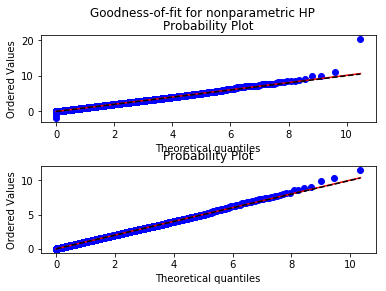

In [6]:
def plot_resid(resid,rows,cols):
    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Goodness-of-fit for nonparametric HP')

    for ax,res in zip(axes,resid):
        k = stats.probplot(res, dist=stats.expon, fit=True, plot=ax, rvalue=False)
        ax.plot(k[0][0], k[0][0], 'k--')
        print(stats.kstest(res[np.logical_not(np.isnan(res))], 'expon'))
plot_resid(residuals,2,1)

### Non - Parametric Estimation

Lets use events from the HP generated in the parametric section and try to retrieve kernels and baselines using a nonparametric method.

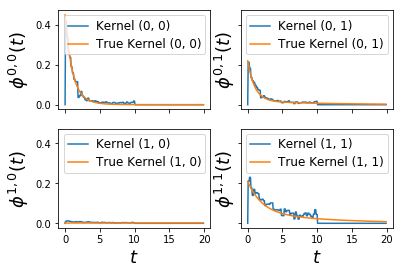

In [7]:
import itertools

# And then perform estimation with two basis kernels
kernel_support = 10
n_basis = 3
kernel_size = 50
max_iter = 200

em = HawkesBasisKernels(kernel_support, n_basis=n_basis,
                        kernel_size=kernel_size, n_threads=4,
                        max_iter=max_iter, verbose=False, ode_tol=1e-5)
em.fit(arrivals)

fig = plot_hawkes_kernels(em, hawkes=hawkes_exp_kernels, support=19.9, show=False)


Since nonparametric learners don't have method .estimated_intensity we have to come up with a workaround. We use a general simulation Hawkes object SimuHawkes that allows for tracking the intensity. 
- So first initialize a SimuHawkes with baselines from the nonpar learner.
- Second assign numerically approximated kernels from the non-par method to the SimuHawkes object
- Lastly turn on .track_intensity with a given step resolution

This allows us to access SimuHawkes.track_intensity which will be an approximation of the intensity under non-par learner

In [16]:
step = 0.01
hp = SimuHawkes(baseline = em.baseline)
support = np.arange(0,np.max(em.get_kernel_supports()),step)

for i, j in itertools.product(range(em.n_nodes), repeat=2):
    print([i,j])
    y = em.get_kernel_values(i,j,support)
    kernel = HawkesKernelTimeFunc(t_values=support, y_values=y)
    hp.set_kernel(i, j, kernel)
    
hp.track_intensity(step)
hp.set_timestamps(timestamps = arrivals)

[0, 0]
[0, 1]
[1, 0]
[1, 1]


Since HP is set, we can do hp.intensity_tracked_times and hp.tracked intensity, which then can be passed to our resid method implemented earlier.

In [17]:
def goodness_of_fit_nonpar(hp, arrivals, method):
    dimension = hp.n_nodes
    intensities = hp.tracked_intensity
    x = hp.intensity_tracked_times
    residuals = [resid(x,intensities,arrivals,dim, method) for dim in range(dimension)]
    return residuals

residualsnp = goodness_of_fit_nonpar(hp,hp.timestamps, integrate.simps)   

KstestResult(statistic=0.006364475833863126, pvalue=0.27398736539259966)
KstestResult(statistic=0.004819274822057393, pvalue=0.6994056681527173)


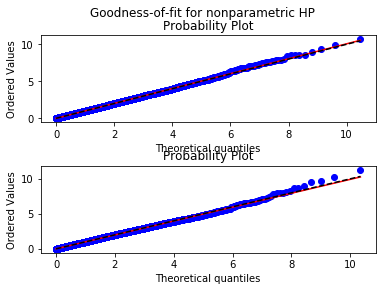

In [18]:
plot_resid(residualsnp,2,1)

And to include everything in one func given only a non parametric learner, timestamps, timestep and integration method:

In [31]:
def goodness_of_fit_nonpar(nplearner, arrivals, timestep, method):
    # setup simulation object
    hp = SimuHawkes(baseline = nplearner.baseline)
    # set kernels
    support = np.arange(0,np.max(nplearner.get_kernel_supports()),timestep)
    
    for i, j in itertools.product(range(nplearner.n_nodes), repeat=2):
        print('Kernel {} set.'.format([i,j]))
        y = nplearner.get_kernel_values(i,j,support)
        kernel = HawkesKernelTimeFunc(t_values=support, y_values=y)
        hp.set_kernel(i, j, kernel)
        
    hp.track_intensity(timestep)
    hp.set_timestamps(timestamps = arrivals)    
    dimension = hp.n_nodes
    intensities = hp.tracked_intensity
    x = hp.intensity_tracked_times
    residuals = [resid(x,intensities,arrivals, dim, method) for dim in range(dimension)]
    return residuals

#residualsnp = goodness_of_fit_nonpar(em, arrivals, 0.1, integrate.simps)  

KstestResult(statistic=0.006364475833863126, pvalue=0.27398736539259966)
KstestResult(statistic=0.004819274822057393, pvalue=0.6994056681527173)


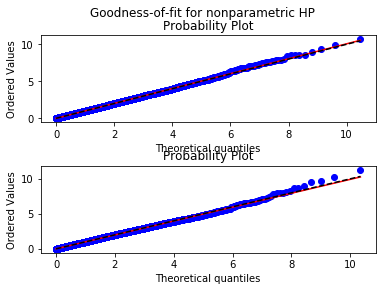

In [20]:
plot_resid(residualsnp,2,1)

# Paralelise Resid

Define timeit decorator:

In [21]:
import time

def timed(method,*args, **kw):
    ts = time.time()
    result = method(*args, **kw)
    te = time.time()
    if 'log_time' in kw:
        name = kw.get('log_name', method.__name__.upper())
        kw['log_time'][name] = int((te - ts) * 1000)
    else:
        print('%r  %2.2f ms' % (method.__name__, (te - ts) * 1000))
    return result


In [22]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [23]:
pool = mp.Pool(mp.cpu_count())

In [33]:
def goodness_of_fit_nonpar_paralel(nplearner, arrivals, timestep, method):
    pool = mp.Pool(mp.cpu_count())
    # setup simulation object
    hp = SimuHawkes(baseline = nplearner.baseline)
    # set kernels
    support = np.arange(0,np.max(nplearner.get_kernel_supports()),timestep)
    
    for i, j in itertools.product(range(nplearner.n_nodes), repeat=2):
        print('Kernel {} set.'.format([i,j]))
        y = nplearner.get_kernel_values(i,j,support)
        kernel = HawkesKernelTimeFunc(t_values=support, y_values=y)
        hp.set_kernel(i, j, kernel)
        
    hp.track_intensity(timestep)
    hp.set_timestamps(timestamps = arrivals)    
    dimension = hp.n_nodes
    intensities = hp.tracked_intensity
    x = hp.intensity_tracked_times
    residuals = [pool.apply(resid,(x,intensities,arrivals, dim, method)) for dim in range(dimension)]
    pool.close()
    return residuals

#residualsnp = goodness_of_fit_nonpar(em, arrivals, 0.1, integrate.simps)  

residualsnppar = timed(goodness_of_fit_nonpar_paralel,em,arrivals, 0.05, integrate.simps) 
residualsnp = timed(goodness_of_fit_nonpar,em,arrivals,0.05, integrate.simps) 

Kernel [0, 0] set.
Kernel [0, 1] set.
Kernel [1, 0] set.
Kernel [1, 1] set.
'goodness_of_fit_nonpar_paralel'  32854.46 ms
Kernel [0, 0] set.
Kernel [0, 1] set.
Kernel [1, 0] set.
Kernel [1, 1] set.
'goodness_of_fit_nonpar'  36098.96 ms


residualsnppar